<a href="https://colab.research.google.com/github/MarceleLouiseSAra/TPs-IBD/blob/main/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título:

> *Como a indústria brasileira do entretenimento mudou em duas décadas e o que isso diz sobre os nossos hábitos de consumo*



Membros (nomes e números de matrícula):

> *Marcele Louise Silva Araponga, 2022*****



3) Descrição dos dados:

> Os dados escolhidos para análise exploratória podem ser encontrados [neste](https://dados.gov.br/dados/conjuntos-dados/crt-obras-nao-publicitarias-registradas) link para o Portal de Dados Abertos do Governo Federal. Tratam-se de registros do trâmite de obtenção do CRT, ou "Certificado de Registro de Título", de diferentes obras não publicitárias pela Agência Nacional de Cinema, para que essas possam ser veículas em território brasileiro.

3.1) Entidades:

> Após normalizações, obtêm-se as seguintes entidades:

> • Obra (<u>CRT</u>, tituloBrasil, dataSolicitacao, dataEmissao, situacao, orgTemporal, classificacao, anoInicioProd, tipoObra, segmento, fkCNPJ);

> • obrasSeriadas (<u>fkCRT</u>, <u>anoFimProd</u>, nroTemporadas, dataPiloto);

> • produtoBrasileiro (<u>fkCRT</u>, <u>CPB</u>);

> • obraEstrangeira (<u>fkCRT</u>, <u>ROE</u>, pais, tituloOriginal);

> • Solicitante (<u>CNPJ</u>, causa, registroAncine, redIsen);

> • Endereço (<u>CEP</u>, UF, municipio);

> • relacionamentoSolicitanteEndereço (<u>fkCEP</u>, <u>fkCNPJ</u>).

3.2) Relacionamentos:

> Solicitante e Obra mantêm um relacionamento (1:N) e Obra mantém relacionamentos (1:1) com obrasSeriadas, produtoBrasileiro e obraEstrangeira.

> Alguém pode solicitar várias obras, mas uma obra só pode ter um solicitante; por isso, a relação Obra possui uma chave estrangeira que referencia Solicitante, *fkCNPJ*.

> Como os relacionamentos mantidos entre Obra, obrasSeriadas, produtoBrasileiro e obraEstrangeira não têm caráter obrigatório para nenhuma das entidades participantes, a melhor opção é a adição de uma coluna referente a uma chave estrangeira.

> Foi criada a entidade *Endereço*, que não existia originalmente no dataset, para ilustrar um relacionamento (N:M); uma produtora (*Solicitante*) pode ter sedes em vários endereços, assim como um mesmo  endereço (isto é, cidade e estado) podem sediar diferentes produtoras. Segundo as regras de mapeamento, esse tipo de relacionamento deve receber uma tabela própria, cuja chave-primária é composta e formada por duas chaves-entrangeiras: uma que referencia Solicitante e outra que referencia Endereço.

> Em adição, *obrasSeriadas*, *produtoBrasileiro* e *obraEstrangeira* foram consideradas entidades fracas e, por isso, têm chave-primária composta formada por uma chave-estrangeira que referencia a entidade proprietária (*Obra*).

3.3) Normalizações:

> A 1ª forma normal estabelece que não devem existir atributos multivalorados e/ou tabelas aninhadas em esquemas relacionais. Os dados originais já não possuíam tais características.

> Esquemas relacionais na 2ª forma normal não devem ter dependência parcial de atributos chave; isto é, todos os atributos não-chave devem depender inteiramente da chave-primária. Por isso, os atributos *tituloOriginal* e *país* foram movidos para a relação *obraEstrangeira*, cuja chave-primária é *ROE* ("Registro de Obra Audiovisual Estrangeira").

> Finalmente, segundo a 3ª forma normal, não deve haver dependência transitiva de chave em esquemas relacionais. Dessa forma, foi criado uma relação com os atributos UF e município, pois este dependia daquele; entretanto, foi criada uma chave-primária chamada "CEP", da qual ambos, agora, dependem.

3.4) Configurações iniciais:

In [75]:
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
def fetch(query, conn, formatted=True):
    # execute the query and fetch all rows
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()

    # extract column names from the cursor description
    columns = [desc[0] for desc in cur.description]

    # return a dataframe with column names
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)

def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]

    return columns

def info(table, conn):
    # table constraints (domain, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)

    # entries per column
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']

    # non-null entries per column
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # unique non-null entries per column
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']

    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def display(urls, cols=5):
    # fetch images
    images = []
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            images.append(Image.open(BytesIO(response.content)))

    # calculate the number of rows
    rows = (len(images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.axis("off")  # Hide unused subplots
    plt.tight_layout()
    plt.show()

def hist(data, xlabel='', ylabel='', bins='auto'):
    # convert list of tuples into dataframe
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expand the data based on frequencies
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plot histogram
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

In [77]:
import os

Source = '/content/drive/MyDrive/crt-obras-nao-publicitarias-2002.csv'

try:
    with sqlite3.connect('TP2.db') as conn:
        cur = conn.cursor()

        cur.execute('PRAGMA synchronous = OFF')
        cur.execute('PRAGMA journal_mode = MEMORY')

        BATCH_SIZE = 1000
        cur.execute('BEGIN TRANSACTION')

        with open(Source, 'r') as f:
            reader = csv.reader(f, delimiter=';')
            header = next(reader)

            columns = [f'"{column}"' for column in header]
            create = f'CREATE TABLE IF NOT EXISTS table2002 ({", ".join(columns)})'
            cur.execute(create)

            placeholders = ', '.join(['?'] * len(header))
            insert = f'INSERT INTO table2002 VALUES ({placeholders})'

            batch = []
            for row in reader:
                batch.append(row)
                if len(batch) == BATCH_SIZE:
                    cur.executemany(insert, batch)
                    batch = []

            if batch:
                cur.executemany(insert, batch)

        update = f'UPDATE table2002 SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
        cur.execute(update)

        conn.commit()
        cur.execute('PRAGMA synchronous = FULL')
        cur.execute('PRAGMA journal_mode = DELETE')

except sqlite3.OperationalError as e:
    print(f"Erro de operação do banco de dados: {e}")
    print("Certifique-se de que o arquivo 'TP2.db' não esteja sendo usado por outro processo.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

In [78]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS Obra2002 (
    CRT TEXT PRIMARY KEY,
    tituloOriginal TEXT,
    dataSolicitacao TEXT,
    dataEmissao TEXT,
    situacao TEXT,
    orgTemporal TEXT,
    classificacao TEXT,
    anoInicioProd INTEGER,
    tipoObra TEXT,
    segmento TEXT,
    fkCNPJ TEXT,
    FOREIGN KEY (fkCNPJ) REFERENCES Solicitante2002(CNPJ) ON DELETE SET NULL ON UPDATE CASCADE
  )"""

  cur.execute(create)

In [79]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    Obra2002_columns = [
        "CRT", "tituloOriginal", "dataSolicitacao", "dataEmissao", "situacao",
        "orgTemporal", "classificacao", "anoInicioProd", "tipoObra", "segmento", "fkCNPJ"
    ]

    columns_to_load = ["CRT", "TITULO_ORIGINAL", "DATA_REQUERIMENTO_CRT", "DATA_EMISSAO_CRT", "SITUACAO_CRT", "ORGANIZACAO_TEMPORAL",
                       "CLASSIFICACAO", "ANO_PRODUCAO_INICIAL", "TIPO_OBRA", "SEGMENTO", "CNPJ_REQUERENTE"
    ]

    insert_query = f"""
    INSERT INTO Obra2002 ({', '.join(Obra2002_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2002;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2002 para a tabela Obra2002 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

472 linhas carregadas da table2002 para a tabela Obra2002 com sucesso.


In [80]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS obrasSeriadas2002 (
    fkCRT TEXT,
    anoFimProd INTEGER,
    nroTemporadas INTEGER,
    dataPiloto TEXT,
    PRIMARY KEY (fkCRT, anoFimProd),
    FOREIGN KEY (fkCRT) REFERENCES Obra2002(CRT) ON DELETE SET NULL ON UPDATE CASCADE
  )"""

  cur.execute(create)

In [81]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    obrasSeriadas2002_columns = [
        "fkCRT", "anoFimProd"
    ]

    columns_to_load = [
        "CRT", "ANO_PRODUCAO_FINAL"
    ]

    insert_query = f"""
    INSERT INTO obrasSeriadas2002 ({', '.join(obrasSeriadas2002_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2002 WHERE ORGANIZACAO_TEMPORAL = 'SERIADA' OR
                   ORGANIZACAO_TEMPORAL = 'SERIADA DE DURAÇÃO INDETERMINADA' OR
                   ORGANIZACAO_TEMPORAL = 'SERIADA EM MÚLTIPLAS TEMPORADAS' OR
                   ORGANIZACAO_TEMPORAL = 'SERIADA EM TEMPORADA ÚNICA';
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2002 para a tabela obrasSeriadas2002 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

19 linhas carregadas da table2002 para a tabela obrasSeriadas2002 com sucesso.


In [82]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS produtoBrasileiro2002 (
      fkCRT TEXT,
      CPB TEXT,
      PRIMARY KEY (fkCRT, CPB),
      FOREIGN KEY (fkCRT) REFERENCES Obra2002(CRT) ON DELETE SET NULL ON UPDATE CASCADE
  )"""

  cur.execute(create)

In [83]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    produtoBrasileiro2002_columns = [
        "fkCRT", "CPB"
    ]

    columns_to_load = [
        "CRT", "CPB_ROE"
    ]

    insert_query = f"""
    INSERT INTO produtoBrasileiro2002 ({', '.join(produtoBrasileiro2002_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2002 WHERE pais = 'BRASIL';
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2002 para a tabela produtoBrasileiro2002 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

72 linhas carregadas da table2002 para a tabela produtoBrasileiro2002 com sucesso.


In [84]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS obraEstrangeira2002 (
      fkCRT TEXT,
      ROE TEXT,
      pais TEXT,
      tituloBrasil TEXT,
      PRIMARY KEY (fkCRT, ROE),
      FOREIGN KEY (fkCRT) REFERENCES Obra2002(CRT) ON DELETE SET NULL ON UPDATE CASCADE
    )"""

  cur.execute(create)

In [85]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    obraEstrangeira2002_columns = [
        "fkCRT", "ROE", "pais", "tituloBrasil"
    ]

    columns_to_load = [
        "CRT", "CPB_ROE", "PAIS", "TITULO_BRASIL"
    ]

    insert_query = f"""
    INSERT INTO obraEstrangeira2002 ({', '.join(obraEstrangeira2002_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2002 WHERE pais != 'BRASIL';
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2002 para a tabela obraEstrangeira2002 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

400 linhas carregadas da table2002 para a tabela obraEstrangeira2002 com sucesso.


In [86]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS Solicitante2002 (
      CNPJ TEXT PRIMARY KEY,
      causa TEXT,
      registroAncine TEXT,
      redIsen TEXT
    )"""

  cur.execute(create)

In [87]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    Solicitante2002_columns = [
        "CNPJ", "causa", "registroAncine", "redIsen"
    ]

    columns_to_load = [
        "CNPJ_REQUERENTE", "REQUERENTE", "REGISTRO_ANCINE_REQUERENTE", "REDUCAO_ISENCAO"
    ]

    insert_query = f"""
    INSERT INTO Solicitante2002 ({', '.join(Solicitante2002_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2002 GROUP BY CNPJ_REQUERENTE;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2002 para a tabela Solicitante2002 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

56 linhas carregadas da table2002 para a tabela Solicitante2002 com sucesso.


In [88]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS Endereco2002 (
      CEP TEXT PRIMARY KEY,
      UF TEXT,
      municipio TEXT
    )"""

  cur.execute(create)

In [89]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    Endereco2002_columns = [
        "UF", "municipio"
    ]

    columns_to_load = [
        "UF_REQUERENTE", "MUNICIPIO_REQUERENTE"
    ]

    insert_query = f"""
    INSERT INTO Endereco2002 ({', '.join(Endereco2002_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2002;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2002 para a tabela Endereco2002 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

472 linhas carregadas da table2002 para a tabela Endereco2002 com sucesso.


In [90]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS relacionamentoSolicitanteEndereco2002 (
      id INTEGER PRIMARY KEY AUTOINCREMENT,
      fkUF TEXT,
      fkCNPJ TEXT,
      FOREIGN KEY (fkUF) REFERENCES Endereco2002(UF) ON DELETE SET NULL ON UPDATE CASCADE,
      FOREIGN KEY (fkCNPJ) REFERENCES Solicitante2002(CNPJ) ON DELETE SET NULL ON UPDATE CASCADE
    )"""

  cur.execute(create)

In [91]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    relacionamentoSolicitanteEndereco2002_columns = [
        "fkUF", "fkCNPJ"
    ]

    columns_to_load = [
        "UF_REQUERENTE", "CNPJ_REQUERENTE"
    ]

    insert_query = f"""
    INSERT INTO relacionamentoSolicitanteEndereco2002 ({', '.join(relacionamentoSolicitanteEndereco2002_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2002;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2002 para a tabela relacionamentoSolicitanteEndereco2002 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

472 linhas carregadas da table2002 para a tabela relacionamentoSolicitanteEndereco2002 com sucesso.


In [92]:
import os

Source = '/content/drive/MyDrive/crt-obras-nao-publicitarias-2025.csv'

try:
    with sqlite3.connect('TP2.db') as conn:
        cur = conn.cursor()

        cur.execute('PRAGMA synchronous = OFF')
        cur.execute('PRAGMA journal_mode = MEMORY')

        BATCH_SIZE = 1000
        cur.execute('BEGIN TRANSACTION')

        with open(Source, 'r') as f:
            reader = csv.reader(f, delimiter=';')
            header = next(reader)

            columns = [f'"{column}"' for column in header]
            create = f'CREATE TABLE IF NOT EXISTS table2025 ({", ".join(columns)})'
            cur.execute(create)

            placeholders = ', '.join(['?'] * len(header))
            insert = f'INSERT INTO table2025 VALUES ({placeholders})'

            batch = []
            for row in reader:
                batch.append(row)
                if len(batch) == BATCH_SIZE:
                    cur.executemany(insert, batch)
                    batch = []

            if batch:
                cur.executemany(insert, batch)

        update = f'UPDATE table2025 SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
        cur.execute(update)

        conn.commit()
        cur.execute('PRAGMA synchronous = FULL')
        cur.execute('PRAGMA journal_mode = DELETE')

except sqlite3.OperationalError as e:
    print(f"Erro de operação do banco de dados: {e}")
    print("Certifique-se de que o arquivo 'TP2.db' não esteja sendo usado por outro processo.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

In [93]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS Obra2025 (
    CRT TEXT PRIMARY KEY,
    tituloOriginal TEXT,
    dataSolicitacao TEXT,
    dataEmissao TEXT,
    situacao TEXT,
    orgTemporal TEXT,
    classificacao TEXT,
    anoInicioProd INTEGER,
    tipoObra TEXT,
    segmento TEXT,
    fkCNPJ TEXT,
    FOREIGN KEY (fkCNPJ) REFERENCES Solicitante2025(CNPJ) ON DELETE SET NULL ON UPDATE CASCADE
  )"""

  cur.execute(create)

In [94]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    Obra2025_columns = [
        "CRT", "tituloOriginal", "dataSolicitacao", "dataEmissao", "situacao",
        "orgTemporal", "classificacao", "anoInicioProd", "tipoObra", "segmento", "fkCNPJ"
    ]

    columns_to_load = ["CRT", "TITULO_ORIGINAL", "DATA_REQUERIMENTO_CRT", "DATA_EMISSAO_CRT", "SITUACAO_CRT", "ORGANIZACAO_TEMPORAL",
                       "CLASSIFICACAO", "ANO_PRODUCAO_INICIAL", "TIPO_OBRA", "SEGMENTO", "CNPJ_REQUERENTE"
    ]

    insert_query = f"""
    INSERT INTO Obra2025 ({', '.join(Obra2025_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2025;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2025 para a tabela Obra2025 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

2339 linhas carregadas da table2025 para a tabela Obra2025 com sucesso.


In [95]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS obrasSeriadas2025 (
    fkCRT TEXT,
    anoFimProd INTEGER,
    nroTemporadas INTEGER,
    dataPiloto TEXT,
    PRIMARY KEY (fkCRT, anoFimProd),
    FOREIGN KEY (fkCRT) REFERENCES Obra2025(CRT) ON DELETE SET NULL ON UPDATE CASCADE
  )"""

  cur.execute(create)

In [96]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    obrasSeriadas2025_columns = [
        "fkCRT", "anoFimProd"
    ]

    columns_to_load = [
        "CRT", "ANO_PRODUCAO_FINAL"
    ]

    insert_query = f"""
    INSERT INTO obrasSeriadas2025 ({', '.join(obrasSeriadas2025_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2025 WHERE ORGANIZACAO_TEMPORAL = 'SERIADA' OR
                   ORGANIZACAO_TEMPORAL = 'SERIADA DE DURAÇÃO INDETERMINADA' OR
                   ORGANIZACAO_TEMPORAL = 'SERIADA EM MÚLTIPLAS TEMPORADAS' OR
                   ORGANIZACAO_TEMPORAL = 'SERIADA EM TEMPORADA ÚNICA';
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2025 para a tabela obrasSeriadas2025 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

779 linhas carregadas da table2025 para a tabela obrasSeriadas2025 com sucesso.


In [97]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS produtoBrasileiro2025 (
      fkCRT TEXT,
      CPB TEXT,
      PRIMARY KEY (fkCRT, CPB),
      FOREIGN KEY (fkCRT) REFERENCES Obra2025(CRT) ON DELETE SET NULL ON UPDATE CASCADE
  )"""

  cur.execute(create)

In [98]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    produtoBrasileiro2025_columns = [
        "fkCRT", "CPB"
    ]

    columns_to_load = [
        "CRT", "CPB_ROE"
    ]

    insert_query = f"""
    INSERT INTO produtoBrasileiro2025 ({', '.join(produtoBrasileiro2025_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2025 WHERE pais = 'BRASIL';
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2025 para a tabela produtoBrasileiro2025 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

1429 linhas carregadas da table2025 para a tabela produtoBrasileiro2025 com sucesso.


In [99]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS obraEstrangeira2025 (
      fkCRT TEXT,
      ROE TEXT,
      pais TEXT,
      tituloBrasil TEXT,
      PRIMARY KEY (fkCRT, ROE),
      FOREIGN KEY (fkCRT) REFERENCES Obra2025(CRT) ON DELETE SET NULL ON UPDATE CASCADE
    )"""

  cur.execute(create)

In [100]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    obraEstrangeira2025_columns = [
        "fkCRT", "ROE", "pais", "tituloBrasil"
    ]

    columns_to_load = [
        "CRT", "CPB_ROE", "PAIS", "TITULO_BRASIL"
    ]

    insert_query = f"""
    INSERT INTO obraEstrangeira2025 ({', '.join(obraEstrangeira2025_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2025 WHERE pais != 'BRASIL';
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2025 para a tabela obraEstrangeira2025 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

910 linhas carregadas da table2025 para a tabela obraEstrangeira2025 com sucesso.


In [101]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS Solicitante2025 (
      CNPJ TEXT PRIMARY KEY,
      causa TEXT,
      registroAncine TEXT,
      redIsen TEXT
    )"""

  cur.execute(create)

In [102]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    Solicitante2025_columns = [
        "CNPJ", "causa", "registroAncine", "redIsen"
    ]

    columns_to_load = [
        "CNPJ_REQUERENTE", "REQUERENTE", "REGISTRO_ANCINE_REQUERENTE", "REDUCAO_ISENCAO"
    ]

    insert_query = f"""
    INSERT INTO Solicitante2025 ({', '.join(Solicitante2025_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2025 GROUP BY CNPJ_REQUERENTE;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2025 para a tabela Solicitante2025 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

401 linhas carregadas da table2025 para a tabela Solicitante2025 com sucesso.


In [103]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS Endereco2025 (
      CEP TEXT PRIMARY KEY,
      UF TEXT,
      municipio TEXT
    )"""

  cur.execute(create)

In [104]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    Endereco2025_columns = [
        "UF", "municipio"
    ]

    columns_to_load = [
        "UF_REQUERENTE", "MUNICIPIO_REQUERENTE"
    ]

    insert_query = f"""
    INSERT INTO Endereco2025 ({', '.join(Endereco2025_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2025;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2025 para a tabela Endereco2025 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

2339 linhas carregadas da table2025 para a tabela Endereco2025 com sucesso.


In [105]:
with sqlite3.connect('TP2.db') as conn:
  cur = conn.cursor()

  create = f"""CREATE TABLE IF NOT EXISTS relacionamentoSolicitanteEndereco2025 (
      id INTEGER PRIMARY KEY AUTOINCREMENT,
      fkUF TEXT,
      fkCNPJ TEXT,
      FOREIGN KEY (fkUF) REFERENCES Endereco2025(UF) ON DELETE SET NULL ON UPDATE CASCADE,
      FOREIGN KEY (fkCNPJ) REFERENCES Solicitante2025(CNPJ) ON DELETE SET NULL ON UPDATE CASCADE
    )"""

  cur.execute(create)

In [106]:
import sqlite3

with sqlite3.connect('TP2.db') as conn:
    cur = conn.cursor()

    relacionamentoSolicitanteEndereco2025_columns = [
        "fkUF", "fkCNPJ"
    ]

    columns_to_load = [
        "UF_REQUERENTE", "CNPJ_REQUERENTE"
    ]

    insert_query = f"""
    INSERT INTO relacionamentoSolicitanteEndereco2025 ({', '.join(relacionamentoSolicitanteEndereco2025_columns)})
    SELECT {', '.join(columns_to_load)}
    FROM table2025;
    """

    try:
        cur.execute(insert_query)

        conn.commit()
        print(f"{cur.rowcount} linhas carregadas da table2025 para a tabela relacionamentoSolicitanteEndereco2025 com sucesso.")

    except sqlite3.OperationalError as e:
        print(f"Erro de operação do banco de dados ao carregar dados: {e}")
        conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        conn.rollback()

2339 linhas carregadas da table2025 para a tabela relacionamentoSolicitanteEndereco2025 com sucesso.


In [107]:
# show tables
show_tables(conn)

['sqlite_sequence',
 'table2002',
 'Obra2002',
 'obrasSeriadas2002',
 'produtoBrasileiro2002',
 'obraEstrangeira2002',
 'Solicitante2002',
 'Endereco2002',
 'relacionamentoSolicitanteEndereco2002',
 'table2025',
 'Obra2025',
 'obrasSeriadas2025',
 'produtoBrasileiro2025',
 'obraEstrangeira2025',
 'Solicitante2025',
 'Endereco2025',
 'relacionamentoSolicitanteEndereco2025']

4) Diagrama ER:

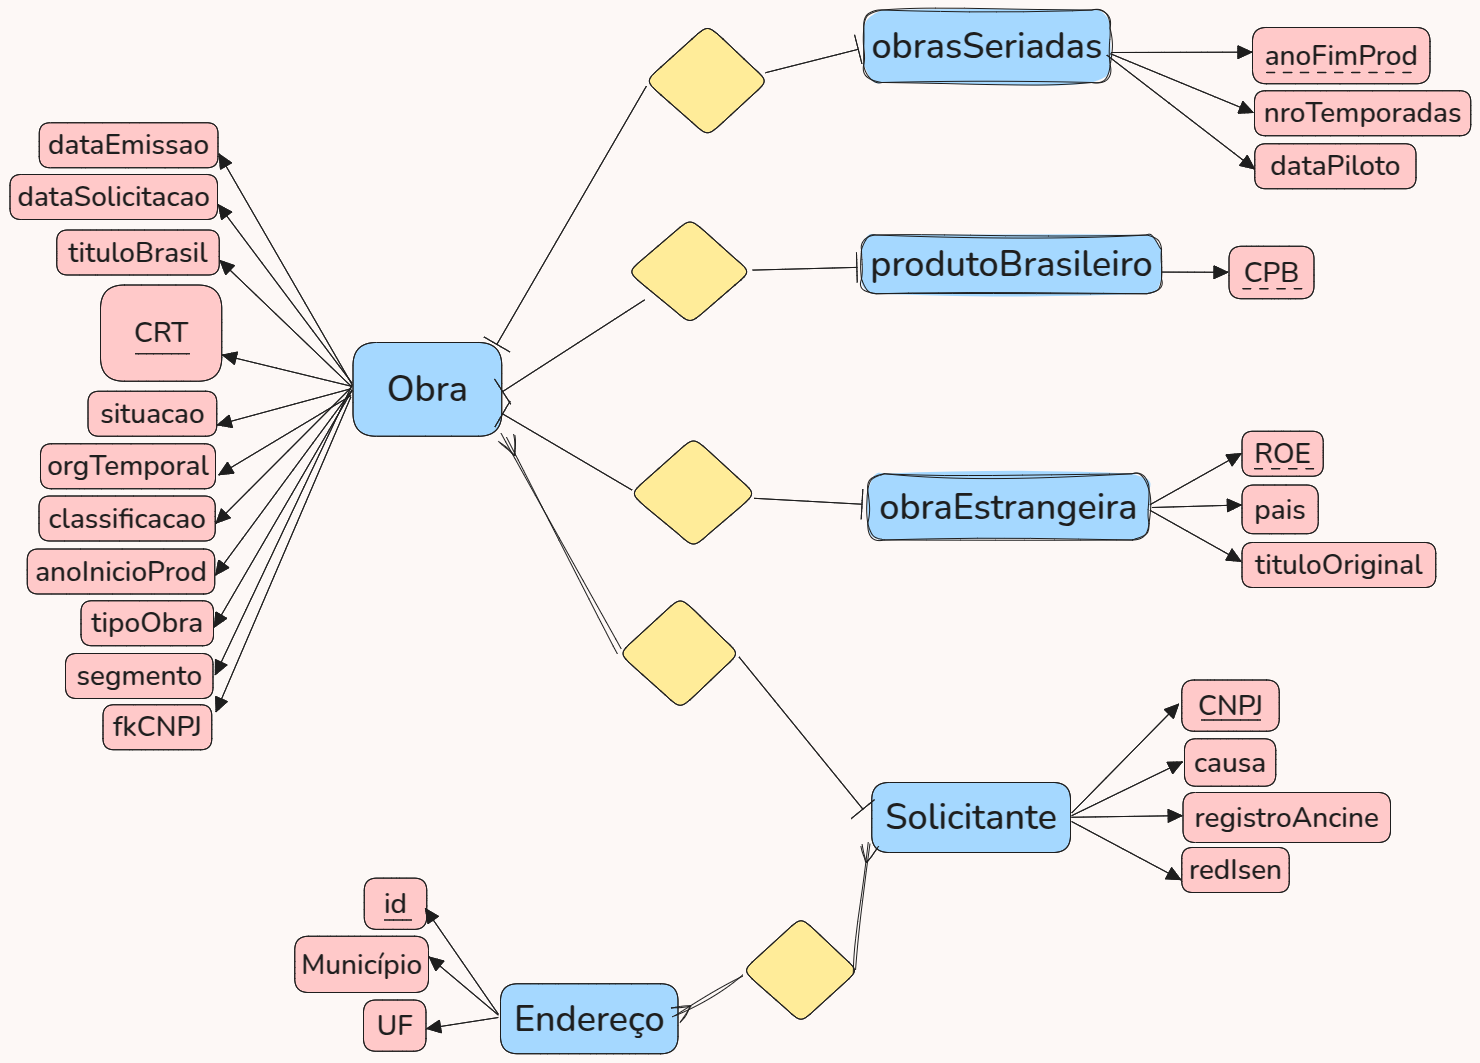

5) Diagrama relacional:

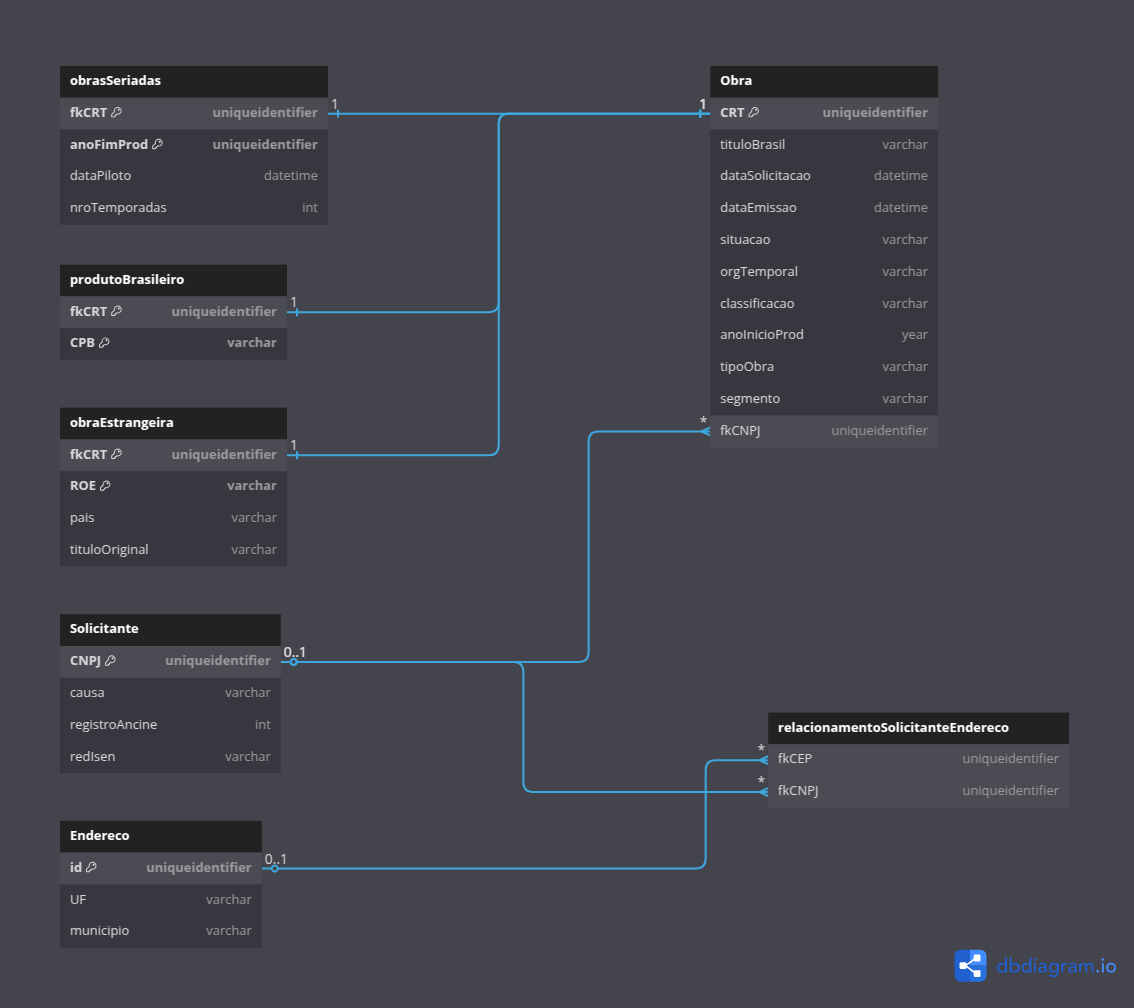

6) Consultas:

6.1) Duas consultas envolvendo relação e projeção:



  6.1.1) 1ª consulta:

In [108]:
fetch("""
  SELECT COUNT(*), anoInicioProd FROM Obra2025 WHERE anoInicioProd = 2025
""", conn)

,COUNT(*),anoInicioProd
0,878,2025


In [109]:
fetch("""
  SELECT COUNT(*), anoInicioProd FROM Obra2002 WHERE anoInicioProd = 2002
""", conn)

,COUNT(*),anoInicioProd
0,128,2002


Em 2002, cerca de 27% dos filmes que requeriram o CRT em 2002 eram desse mesmo ano, enquanto em 2025, aproximadamente 37,5% das obras foram lançadas no mesmo ano.

  6.1.1) 2ª consulta:

In [110]:
fetch("""
  SELECT COUNT(*), orgTemporal FROM Obra2002 GROUP BY orgTemporal
""", conn)

,COUNT(*),orgTemporal
0,453,NÃO SERIADA
1,19,SERIADA


In [111]:
fetch("""
  SELECT COUNT(*), orgTemporal FROM Obra2025 GROUP BY orgTemporal
""", conn)

,COUNT(*),orgTemporal
0,1560,NÃO SERIADA
1,7,SERIADA
2,194,SERIADA DE DURAÇÃO INDETERMINADA
3,354,SERIADA EM MÚLTIPLAS TEMPORADAS
4,224,SERIADA EM TEMPORADA ÚNICA


Em 2002, cerca de 96% das obras eram não seriadas. Ao longo de duas décadas, a demanda por esse tipo de produção diminui para 66,7%, ao passo que outras (minisséries) passaram a ser especificas. Não é possível dizer se produções de uma só temporada não eram demandadas ou se isso só foi subnotificado.

6.2) Três consultas envolvendo junção de duas relações:

6.2.1) 1ª consulta:



In [112]:
fetch("""
  SELECT DISTINCT Solicitante2002.CNPJ FROM Obra2025, Solicitante2002 WHERE Obra2025.fkCNPJ = Solicitante2002.CNPJ GROUP BY Solicitante2002.CNPJ
""", conn)

,CNPJ
0,00.252.848/0001-08
1,00.979.601/0001-98
2,01.253.766/0001-40
3,02.605.295/0001-55
4,02.668.665/0001-01
5,02.745.624/0001-63
6,03.599.148/0001-82
7,27.654.722/0001-16
8,27.865.757/0001-02
9,31.179.864/0001-46


12 produtoras que atuavam em 2002 ainda atuam em 2025.

6.2.2) 2ª consulta:



In [126]:
fetch("""
  SELECT DISTINCT o.pais FROM obraEstrangeira2002 AS o INNER JOIN Obra2002 AS s ON o.fkCRT = s.CRT
""", conn)

,pais
0,ESTADOS UNIDOS
1,MÉXICO
2,FRANÇA
3,ARGENTINA
4,INGLATERRA
5,ESPANHA
6,ITÁLIA
7,AUSTRÁLIA
8,JAPÃO
9,TAILÂNDIA


In [127]:
fetch("""
  SELECT DISTINCT o.pais FROM obraEstrangeira2025 AS o INNER JOIN Obra2025 AS s ON o.fkCRT = s.CRT
""", conn)

,pais
0,ESPANHA
1,ESTADOS UNIDOS
2,INGLATERRA
3,ALEMANHA
4,CORÉIA DO SUL
5,FRANÇA
6,JAPÃO
7,ESLOVÁQUIA
8,BÉLGICA
9,ÍNDIA


Em 2002, o Brasil importava obras não publicitárias de 20 países diferentes. Em 2025, consumimos produções de 39 países.

6.2.3) 3ª consulta:



In [144]:
fetch("""
  SELECT COUNT(*) FROM Obra2002 AS A, produtoBrasileiro2002 AS B WHERE A.CRT = B.fkCRT
""", conn)

,COUNT(*)
0,72


In [145]:
fetch("""
  SELECT COUNT(*) FROM Obra2025 AS A, produtoBrasileiro2025 AS B WHERE A.CRT = B.fkCRT
""", conn)

,COUNT(*)
0,1429


Em 2002, pouco mais de 15% das obras não publicitárias consumidas eram brasileiras. Em 2025, essa parcela corresponde a mais de 61%.

6.3) Três consultas envolvendo junção de três ou mais relações:

6.3.1) 1ª consulta:

In [123]:
fetch("""
  SELECT * FROM Obra2002 AS A, obrasSeriadas2002 AS B, produtoBrasileiro2002 AS C WHERE A.CRT = B.fkCRT AND A.CRT = C.fkCRT
""", conn)

,CRT,tituloOriginal,dataSolicitacao,dataEmissao,situacao,orgTemporal,classificacao,anoInicioProd,tipoObra,segmento,fkCNPJ,fkCRT,anoFimProd,nroTemporadas,dataPiloto,fkCRT,CPB
0,04010000325320026,AUTO DA COMPADECIDA,05/09/2002,09/09/2002,EXPIRADO,SERIADA,BRASILEIRA CONSTITUINTE DE ESPAÇO QUALIFICADO,1999,FICÇÃO,COMUNICAÇÃO ELETRÔNICA DE MASSA POR ASSINATURA...,27.865.757/0001-02,04010000325320026,1999,None,None,04010000325320026,B0500291400000


In [125]:
fetch("""
  SELECT COUNT(*) FROM Obra2025 AS A, obrasSeriadas2025 AS B, produtoBrasileiro2025 AS C WHERE A.CRT = B.fkCRT AND A.CRT = C.fkCRT
""", conn)

,COUNT(*)
0,620


Em 2002, somente uma obra não publicitária seriada brasileira requeriu a emissão do CRT, em contraponto com 620 em 2025.

6.3.2) 2ª consulta:

In [130]:
fetch("""
  SELECT COUNT(*) FROM Obra2002 AS A, obrasSeriadas2002 AS B, obraEstrangeira2002 AS C WHERE A.CRT = B.fkCRT AND A.CRT = C.fkCRT
""", conn)

,COUNT(*)
0,18


In [131]:
fetch("""
  SELECT COUNT(*) FROM Obra2025 AS A, obrasSeriadas2025 AS B, obraEstrangeira2025 AS C WHERE A.CRT = B.fkCRT AND A.CRT = C.fkCRT
""", conn)

,COUNT(*)
0,159


Ao mesmo tempo, em 2002, 18 das produções estrangeiras eram seriadas, enquanto em 2025, 159 do total o são.

6.3.3) 3ª consulta:

In [141]:
fetch("""
  SELECT C.pais, COUNT(*) FROM Obra2002 AS A, obrasSeriadas2002 AS B, obraEstrangeira2002 AS C WHERE A.CRT = B.fkCRT AND A.CRT = C.fkCRT GROUP BY C.pais ORDER BY COUNT(*) DESC LIMIT 3
""", conn)

,pais,COUNT(*)
0,ESTADOS UNIDOS,8
1,VENEZUELA,5
2,JAPÃO,2


In [142]:
fetch("""
  SELECT C.pais, COUNT(*) FROM Obra2025 AS A, obrasSeriadas2025 AS B, obraEstrangeira2025 AS C WHERE A.CRT = B.fkCRT AND A.CRT = C.fkCRT GROUP BY C.pais ORDER BY COUNT(*) DESC LIMIT 3
""", conn)

,pais,COUNT(*)
0,ESTADOS UNIDOS,86
1,MÉXICO,29
2,CORÉIA DO SUL,7


Em duas décadas, os Estados Unidos continua sendo o maior exportador de obras seriadas para o Brasil. Entretanto, representava 42% das obras em 2002, enquanto em 2025, representa 11%.

6.4) Duas consultas envolvendo agregação sobre junção de duas ou mais relações:

6.4.1) 1ª consulta:

In [164]:
fetch("""
  SELECT AVG(julianday(SUBSTR(dataEmissao, 7, 4) || '-' || SUBSTR(dataEmissao, 4, 2) || '-' || SUBSTR(dataEmissao, 1, 2)) -
         julianday(SUBSTR(dataSolicitacao, 7, 4) || '-' || SUBSTR(dataSolicitacao, 4, 2) || '-' || SUBSTR(dataSolicitacao, 1, 2))) AS mediaDiasEntreDatas, dataEmissao, dataSolicitacao
         FROM Obra2002 AS A, produtoBrasileiro2002 AS B WHERE dataEmissao IS NOT NULL AND dataSolicitacao IS NOT NULL AND A.CRT = B.fkCRT
""", conn)

,mediaDiasEntreDatas,dataEmissao,dataSolicitacao
0,10.5,13/11/2002,24/10/2002


In [166]:
fetch("""
  SELECT AVG(julianday(SUBSTR(dataEmissao, 7, 4) || '-' || SUBSTR(dataEmissao, 4, 2) || '-' || SUBSTR(dataEmissao, 1, 2)) -
         julianday(SUBSTR(dataSolicitacao, 7, 4) || '-' || SUBSTR(dataSolicitacao, 4, 2) || '-' || SUBSTR(dataSolicitacao, 1, 2))) AS mediaDiasEntreDatas, dataEmissao, dataSolicitacao
         FROM Obra2025 AS A, produtoBrasileiro2025 AS B WHERE dataEmissao IS NOT NULL AND dataSolicitacao IS NOT NULL AND A.CRT = B.fkCRT
""", conn)

,mediaDiasEntreDatas,dataEmissao,dataSolicitacao
0,11.051784,18/02/2025,17/02/2025


O tempo médio de tempo que demorava-se para que o CRT de produções brasileiras fosse emito era praticamente o mesmo em 2002 do que é em 2025.

6.4.2) 2ª consulta:

In [167]:
fetch("""
  SELECT AVG(julianday(SUBSTR(dataEmissao, 7, 4) || '-' || SUBSTR(dataEmissao, 4, 2) || '-' || SUBSTR(dataEmissao, 1, 2)) -
         julianday(SUBSTR(dataSolicitacao, 7, 4) || '-' || SUBSTR(dataSolicitacao, 4, 2) || '-' || SUBSTR(dataSolicitacao, 1, 2))) AS mediaDiasEntreDatas, dataEmissao, dataSolicitacao
         FROM Obra2002 AS A, obraEstrangeira2002 AS B WHERE dataEmissao IS NOT NULL AND dataSolicitacao IS NOT NULL AND A.CRT = B.fkCRT
""", conn)

,mediaDiasEntreDatas,dataEmissao,dataSolicitacao
0,20.38,15/07/2002,18/06/2002


In [168]:
fetch("""
  SELECT AVG(julianday(SUBSTR(dataEmissao, 7, 4) || '-' || SUBSTR(dataEmissao, 4, 2) || '-' || SUBSTR(dataEmissao, 1, 2)) -
         julianday(SUBSTR(dataSolicitacao, 7, 4) || '-' || SUBSTR(dataSolicitacao, 4, 2) || '-' || SUBSTR(dataSolicitacao, 1, 2))) AS mediaDiasEntreDatas, dataEmissao, dataSolicitacao
         FROM Obra2025 AS A, obraEstrangeira2025 AS B WHERE dataEmissao IS NOT NULL AND dataSolicitacao IS NOT NULL AND A.CRT = B.fkCRT
""", conn)

,mediaDiasEntreDatas,dataEmissao,dataSolicitacao
0,12.96044,28/03/2025,11/08/2014


O tempo médio de tempo entre a solicitação e a emissão do CRT de produções estrangeiras diminuiu em quase 7 (sete) dias de 2002 para 2025.